In [1]:
import os
import scipy
import scipy.ndimage 
import scipy.misc
from scipy.stats import multivariate_normal as mvn
from scipy.sparse import triu
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from time import time
import glob
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
cwd = os.getcwd()
#path = os.path.join(cwd,'run44_image0','*gain*.npy')
file_list = [ name for name in glob.glob('/Users/vanessa/work/repos/pixel_masking/run44_image0_gain/*')]

In [3]:
def gaussian(x, amp, cen, wid):
    gx = []
    gy = []
    for xv in x:
        gx.append(xv)
        g = amp * np.exp(-(xv-cen)**2 / wid)
        gy.append(g)
    return gx,gy    

In [58]:
def transform_data(np_file):
    panel_mat = np.load(np_file)
    no_nan_panel_mat = np.nan_to_num(panel_mat,nan=0.0)
    flat_panel_mat = panel_mat.flatten()
    no_nan_flat_panel_map = flat_panel_map
    no_nan_flat_panel_map = no_nan_flat_panel_map[~np.isnan(no_nan_flat_panel_map)]

    gain_map = np.isnan(flat_panel_map)
    bad_gain_loc = np.where(gain_map==True)

    #norm = panel_mat/scipy.linalg.norm(panel_mat,2)
    norm = no_nan_panel_mat
    sh1img = scipy.ndimage.shift(norm, 1, order=0, mode='nearest') # l,m = 1
    sh10img = scipy.ndimage.shift(norm, 10, order=0, mode='nearest') # l,m = 10

    d1img = norm - sh1img
    d10img = norm - sh10img
    X1 = d1img.flatten().reshape(-1,1)
    X10 = d10img.flatten().reshape(-1,1)
    
    no_nan_X1 = np.delete(X1,bad_gain_loc[0])
    no_nan_X10 = np.delete(X10,bad_gain_loc[0])
    return norm, d1img, d10img, no_nan_X1, no_nan_X10


In [129]:
def get_local_mat(panel_mat,slow_bounds,fast_bounds):
    if slow_bounds[0] <= 1:
        slow_bounds[0] = 0
    else:
        slow_bounds[0] = slow_bounds[0] - 1
        
    if slow_bounds[1] >= 31:
        slow_bounds[1] = 32
    else:
        slow_bounds[1] = slow_bounds[1]+2
        
    if fast_bounds[0] <= 2:
        fast_bounds[0] = 0
    else:
        fast_bounds[0] = fast_bounds[0] - 2
        
    if fast_bounds[1] >= 125:
        fast_bounds[1] = 128
    else:
        fast_bounds[1] = fast_bounds[1] + 3   

    return panel_mat[slow_bounds[0]:slow_bounds[1]][fast_bounds[0]:fast_bounds[1]], slow_bounds, fast_bounds    


In [135]:
def fill_off_gain_pixels(panel_mat): 
    gain_map = np.isnan(panel_mat)
    bad_gain_loc = np.where(gain_map==True)
    print(f'there are {len(bad_gain_loc[0])} off gain pixels')
    count = 0
    for slow,fast in zip(bad_gain_loc[0],bad_gain_loc[1]):
        slow_bounds = [slow, slow]
        fast_bounds = [fast, fast]
        local_mat, slow_bounds, fast_bounds = get_local_mat(panel_mat, slow_bounds, fast_bounds)
        while (slow_bounds[1]-slow_bounds[0] < 32) and  (fast_bounds[1]-fast_bounds[0] < 128): 
            local_gain_map = np.isnan(local_mat)
            local_bad_gain = np.where(local_gain_map==True)
            flat_local_mat = local_mat.flatten()
            local_size = len(flat_local_mat)
            bad_gain_size = len(local_bad_gain[0])
            if local_size > 4* bad_gain_size:
                #print(local_size, bad_gain_size)
                flat_local_mat = flat_local_mat[~np.isnan(flat_local_mat)]
                avg_val = np.average(flat_local_mat)
                panel_mat[slow][fast] = avg_val
                #print(f'replaced {count} off gain pixel with {avg_val}')
                count = count + 1
                break
            else:
                local_mat, slow_bounds, fast_bounds = get_local_mat(panel_mat, slow_bounds, fast_bounds)   
    return panel_mat            

In [131]:
def transform_data2(np_file):
    panel_mat = np.load(np_file)
    #no_nan_panel_mat = np.nan_to_num(panel_mat,nan=0.0)
    avg_panel_mat = fill_off_gain_pixels(panel_mat)
    #norm = panel_mat/scipy.linalg.norm(panel_mat,2)
    norm = avg_panel_mat
    sh1img = scipy.ndimage.shift(norm, 1, order=0, mode='nearest') # l,m = 1
    sh10img = scipy.ndimage.shift(norm, 10, order=0, mode='nearest') # l,m = 10

    d1img = norm - sh1img
    d10img = norm - sh10img
    X1 = d1img.flatten().reshape(-1,1)
    X10 = d10img.flatten().reshape(-1,1)
    
    return norm, d1img, d10img, X1, X10


In [14]:
def show_transformed_data(norm, d1img, d10img):
    dhist = np.histogram(norm.flatten())
    thist = np.histogram(d10img.flatten())
    max_t_counts = np.max(thist[0])
    max_t_loc = np.where(thist[0]==max_t_counts)

    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(221)
    ax2 = f.add_subplot(222)
    ax3 = f.add_subplot(223)
    ax4 = f.add_subplot(224)

    ax.set_title("Normalized Image")
    p1 = ax.imshow(norm,vmin=np.min(norm.flatten()), vmax=np.max(norm.flatten()),cmap='RdBu');
    ax2.set_title("Bilateral transform")
    p2 = ax2.imshow(d1img,vmin=np.min(d1img.flatten()), vmax=np.max(d1img.flatten()),cmap='RdBu');
    f.colorbar(p1,ax=ax)
    f.colorbar(p2,ax=ax2)
    f.patch.set_visible(False)
    ax.axis('off')
    ax2.axis('off')
    #bin_list = [x/1000 for x in range(-40,40,1)]
    bin_list = [x for x in range(-3000,3000,10)]
    ax3.set_title("Bilateral Trans. Histogram")
    ax3.hist(d1img.flatten(), bins=bin_list, alpha=0.5, label="noiseless");
    ax3.set_ylim([0,60]);

    ax4.set_title("Bilateral Trans. Histogram")
    ax4.hist(d10img.flatten(), bins=bin_list, alpha=0.5, label="noiseless");
    ax4.set_ylim([0,60]);

In [15]:
def print_model_stats(num_distributions, best_mixture_model):
    means = []
    var = []
    for i in range(num_distributions):
        means.append(best_mixture_model.means_[i][0])
        var.append(best_mixture_model.covariances_[i][0][0])
    print('converged?:', best_mixture_model.converged_)
    print('means:', means)
    print('variances:', var)
    return means, var

In [16]:
def ber_demo():
    decision_bound = 1.5
    xr = np.linspace(-10, 10, 100)
    xr2 = np.linspace(decision_bound, 10, 100)
    xr1 = np.linspace(-10, decision_bound, 100)

    g1x,g1y = gaussian(xr,5,3, 1)
    pg1x,pg1y = gaussian(xr1,5,3, 1)
    g2x,g2y = gaussian(xr, 1,0,5)
    pg2x,pg2y = gaussian(xr2,1,0, 5)
    plt.axvline(x = decision_bound, color = 'k', label = 'axvline - full height')
    plt.fill_between(pg1x,pg1y, alpha=0.4,color='b')
    plt.fill_between(pg2x,pg2y, alpha=0.4,color='r')

    plt.plot(g1x, g1y,color='b')
    plt.plot(g2x, g2y,color='r')
    plt.plot(pg1x, pg1y,color='b')
    plt.plot(pg2x, pg2y,color='r')

    plt.annotate('Bayes Error for group 2 ', xy=(1.9, 0.2),  xycoords='data',
                xytext=(1.1, 0.95), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.01),
                horizontalalignment='right', verticalalignment='top',
                )
    plt.annotate('Bayes Error for group 1 ', xy=(1.2, 0.1),  xycoords='data',
                xytext=(0.5, 0.95), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.01),
                horizontalalignment='right', verticalalignment='top',
                )
    plt.title("Bayes Error Rate (BER)")
    plt.show()

In [17]:
def find_best_mixture_model(model, AIC, threshold):
    aic_diff = [np.abs(AIC[n]-AIC[n-1]) for n in range(1,len(AIC))]
    thresholded_diff = np.where(np.asarray(aic_diff)<threshold)
    print(len(thresholded_diff[0]),thresholded_diff[0],thresholded_diff[0][0])
    print(f'AIC threshold met at {int(thresholded_diff[0][0])}, taking {int(thresholded_diff[0][0]-1)} distributions as gmm')
    idx = int(thresholded_diff[0][0]-1)
    return int(thresholded_diff[0][0]), model[idx]

In [18]:
def generate_mask(X, means,model):
    
    # find where pixels don't match any distribution and mask them
    #X_rescale = (1/stdev)*X1[:,0]
    #X_rescale = X_rescale.reshape(-1,1)
    mmin = np.min(np.abs(means))
    if mmin in means:
        center_mean = mmin
    elif -1*mmin in means:
        center_mean = -1*mmin
    good_model_idx = int(np.where(np.asarray(means)==center_mean)[0])
    print(mmin,good_model_idx)
    classed = model.fit_predict(X)
    bad_pixel_idx = np.where(classed!=good_model_idx )[0]
    print(f'number of bad pixels: {len(bad_pixel_idx)}')
    dead_pixels = np.where(X==0.0)[0]
    print(f'number of dead pixels: {len(dead_pixels)}')
    for dp in dead_pixels:
        classed[dp] = 10
    for bp in bad_pixel_idx:
        classed[bp] = 10    
    classed_img = classed.reshape(32, 128)
    #classed_img = classed.reshape(100, 100)
    return classed_img

In [19]:
#TO DO
# try this without normalization of raw data (done)
# DARK DATA!
# water- make sure only one gain mode (ragged tensors, or masks)
# get build working on Maxwell
# different sized BLT

#pseudo code for parallel
# minimum unit of work iterates over image
   # then each mpi rank will process N images num_images/num_ranks (use mod)
# set up accumlator
# acc = np.zeros(modules,slow,fast)
# for i in range(len(images)):
    #if i mod(rank) !=0:
    #    continue
#    for p in range(len(panels)):
        # mask == func(data(slow,fast)) # 0 for good 1 for bad
        # acc[p] += mask # each rank has its own acc copy
# results=com.reduce(acc,dest=0,operator=mpi.sum)    # send all of acc copies to rank0 and reduce
# if rank==0:
     #mask=results>num_images*0.90
#    save mask

### Steps to generate masks
1. Read all images in a dark or water run

2. Parse images by gain mode and memory cell

3. Perform automated classification of pixels for each panel of each image 
    - Generate MAP or MLE for each distribution using EM 
        - Do it using 1 of 2 ways:
           - Bayesian Gaussian Mixture- infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution
           - Gaussian Mixture- estimate the parameters of a Gaussian mixture distribution.
         - Use Akaike information criterion (AIC) to determine number of Gaussian distributions
         - Assign which distribution belongs to the "good" pixel distribution:
              - criteria should include pi (should be large, at least >65%) and mean value being the closest to zero
    - Perform Naive Bayes classification for each pixel using MLE or MAP
    - Generate error estimate for this process
    - 2 outputs are returned using best Gaussian mixture model:
         - Mask map: Each pixel in a panel is assigned a value according to its "goodness":
             -good: 0, bad: 1 (could also add a value -1 for dead possibly)
         - Error map: Bayesian error rate associated with classification for each pixel in the panel
         
4. Collect data from each panel in each image
    - sum that masked pixels from panel over all images in a run
        - mask out pixels for which that pixel was masked some threshold that exceeds summed_pixel_value/num_images
        - possible to combine error statistics in a similar manner?
        
5. Generate mask using data from step 4


### Pixel masking will be performed using a Naive Bayes Classifier for each panel in an image

Classes of pixels will be determined using a Gaussian Mixture Model and the parameters of each Gaussian distribution will be determined using the expectation maximixation algorithm

#### Naive Bayes Classification is calculated:

$$ P(theta_k | data_i) = \frac{P(theta_k) * P(data_i | theta_k)}{\sum P(theta_k) * P(data_i| theta_k)}, \\ $$ 

where

$$data_i$$ 

isn't raw or normalized pixel intensities, but rather transformations of these pixel intensities. In this case we are using, bilateral regularization. There are many, many other ways to approach this, but I think the main goal is to choose a transformation that will yield easly computed statistical distributions (Gaussian, etc.). 

Bilateral regularization is performed as:

#### X<sub>(l,m)</sub> = X − S<sup>l</sup><sub>x</sub>S<sup>m</sup><sub>y</sub> X

S = operators that shift matrix X by l,m

l = integer shift in horizontal direction and m = integer shift in vertical direction

No reflection at borders

### How are errors estimated? 

There are at least two errors associated with this overall approach. 
1.  The error associated with the EM algortithm:
    - Exactly equal to or proportional to the Hessian (or Fisher Information Matrix)
2. The error associated with the Naive Bayes classification:
    

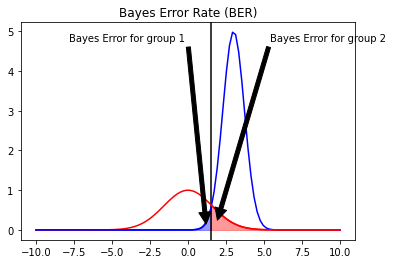

In [20]:
ber_demo()

$$ BER = \int p(x|Y=0)P(Y=0) \, dx  + \int p(x|Y=1)P(Y=1) \, dx,$$ 

where integrating from boundary to infinity

_Let's assume that the Bayes error rate is the error that is most concerning to us_ 

### Mock workflow
#### Step 3. Perform automated classification of pixels for each panel of each image (ignore steps 2 and 3 for now) 

In [74]:
panel_mat = np.load(os.path.join('/Users/vanessa/work/repos/pixel_masking/','data', 'run44_image0_gain2', 'panel_data_19_gain_1counts_3891.npy'))


In [103]:
#flat_panel_map = panel_mat.flatten()
#print(len(flat_panel_map))
#x = flat_panel_map
#x = x[~np.isnan(x)]
#print(len(x))
#def get_no_nan(mat, slow,fast):
#    mat = mat[~np.isnan(mat)]
    
#def avg_local(slow,fast):
    

gain_map = np.isnan(panel_mat)
bad_gain_loc = np.where(gain_map==True)
#print((bad_gain_loc))
#mat = panel_mat
#print(mat.shape)

for slow,fast in zip([1],[1]):
    if slow <= 2:
        slow_bounds = [0,slow+1]
    elif slow >= 31:
        slow_bounds = [slow-1,32]
    else:
        slow_bounds = [slow-1,slow+2]
    if fast <= 2:
        fast_bounds = [0, fast+3]
    elif fast >= 125:
        fast_bounds = [fast-2, 128]
    else:
        fast_bounds = [fast-2, fast+3]   

    print(panel_mat[slow][fast],panel_mat[slow-1][fast-1],panel_mat[slow-2][fast-2])
    while (slow_bounds[1]-slow_bounds[0] < 32) and  (fast_bounds[1]-fast_bounds[0] < 128): 
        local_mat = panel_mat[slow_bounds[0]:slow_bounds[1]][fast_bounds[0]:fast_bounds[1]]
        print(slow,fast,slow_bounds,fast_bounds,local_mat.shape)
        local_gain_map = np.isnan(local_mat)
        local_bad_gain = np.where(local_gain_map==True)
        #print(len(local_bad_gain[0]),local_bad_gain)
        flat_local_mat = local_mat.flatten()
        local_size = len(flat_local_mat)
        bad_gain_size = len(local_bad_gain[0])
        if local_size > 4* bad_gain_size:
            print(local_size, bad_gain_size)
            flat_local_mat = flat_local_mat[~np.isnan(flat_local_mat)]
            avg_val = np.average(flat_local_mat)
            panel_mat[slow][fast] = avg_val
            break
        else:
                if slow <= 2:
                    slow_bounds = [0,slow_bounds[1]+1]
                elif slow >= 31:
                    slow_bounds = [slow_bounds[0]-1,32]
                else:
                    slow_bounds = [slow_bounds[0]-1,slow_bounds[1]+1]
                    
                if fast <= 2:
                    fast_bounds = [0, fast_bounds[1]+3]
                elif fast >= 125:
                    fast_bounds = [fast_bounds[0]-2, 128]
                else:
                    fast_bounds = [fast_bounds[0]-2, fast_bounds[1]+3]   
        
        

nan 2249.1042 10013.84
1 1 [0, 2] [0, 4] (2, 128)
5 (array([1, 1, 1, 1, 1]), array([ 1,  3,  5, 10, 15]))
256 5


In [119]:
x1 = 5
x2 = 6
y1 = 10
y2=12

while (x2-x1 < 32) and  (y2-y1 < 128):
    
    x2 = x2 +1
    
    y2 = y2 +2
    if x2 == 10:
        break
    print(x1,x2,y1,y2)

print("done")

5 7 10 14
5 8 10 16
5 9 10 18
done


In [55]:
print(len(flat_panel_map))
del_map = np.delete(flat_panel_map,bad_gain_loc[0])
print(len(flat_panel_map),len(del_map))

4096
4096 3891


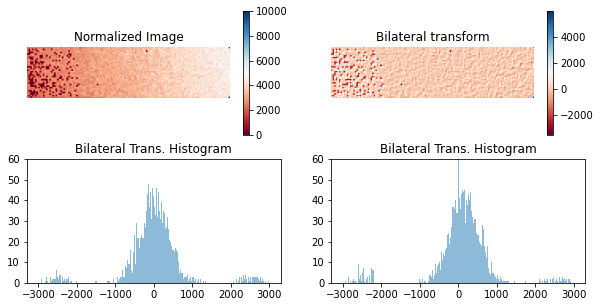

In [63]:
panel_mat = np.load(os.path.join('/Users/vanessa/work/repos/pixel_masking/','data', 'run63_image0_gain', 'dark_panel_data_55_gain_1counts_4096.npy'))

norm, d1img, d10img, no_nan_X1, no_nan_X10 = transform_data(os.path.join('/Users/vanessa/work/repos/pixel_masking/','data', 'run44_image0_gain2', 'panel_data_19_gain_1counts_3891.npy'))
show_transformed_data(norm, d1img, d10img)

there are 205 off gain pixels


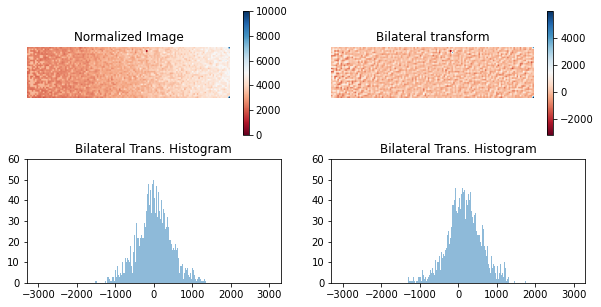

In [136]:
tnorm, td1img, td10img, tno_nan_X1, tno_nan_X10 = transform_data2(os.path.join('/Users/vanessa/work/repos/pixel_masking/','data', 'run44_image0_gain2', 'panel_data_19_gain_1counts_3891.npy'))
show_transformed_data(tnorm, td1img, td10img)

In [158]:
X_rescaled = X1[:,0]/np.std(X1[:,0])
X_rescaled =X_rescaled.reshape(-1,1)
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X_rescaled)

# compute the AIC and the BIC
AIC = [m.aic(X_rescaled) for m in models]
BIC = [m.bic(X_rescaled) for m in models]


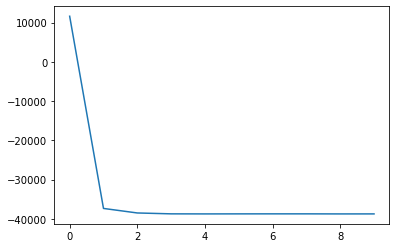

In [159]:
plt.plot(AIC);

In [170]:
num_distributions, best_mixture_model = find_best_mixture_model(models, AIC,1000)

7 [2 3 4 5 6 7 8] 2
AIC threshold met at 2, taking 1 distributions as gmm


In [171]:
means, variances = print_model_stats(num_distributions, best_mixture_model)


converged?: True
means: [-5.7870859871890136e-08, 0.6910487956534995]
variances: [1.0033151088404987e-06, 7.626088504834691]


In [172]:
classed_img = generate_mask(X_rescaled, means,best_mixture_model)

5.7870859871890136e-08 0
number of bad pixels: 509
number of dead pixels: 3584


In [173]:
np.max(classed_img.flatten())

10

(0.0, 50.0)

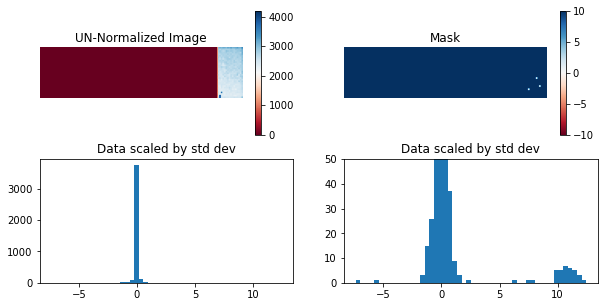

In [174]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.set_title("UN-Normalized Image")
p1 = ax.imshow(norm,vmin=np.min(norm.flatten()), vmax=np.max(norm.flatten()),cmap='RdBu');
ax2.set_title("Mask")
p2 = ax2.imshow(classed_img,vmin=-10, vmax=np.max(classed_img.flatten()),cmap='RdBu');
ax2.set_title("Mask");
f.colorbar(p1,ax=ax)
f.colorbar(p2,ax=ax2)
f.patch.set_visible(False)
ax.axis('off')
ax2.axis('off')
bin_list = [x/1000 for x in range(-40,40,1)]

ax3.set_title("Data scaled by std dev") 
ax3.hist(X_rescaled,bins=50);
ax4.set_title("Data scaled by std dev") 
ax4.hist(X_rescaled,bins=50);
ax4.set_ylim([0,50])

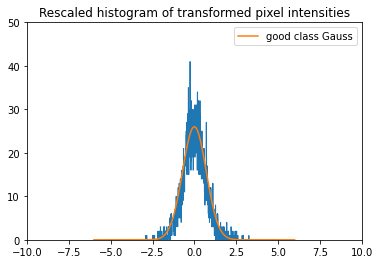

In [127]:
wide_keys = [x/100 for x in range(-500,500,1)]
wide_bins = [x/100 for x in range(-501,500,1)]
phist = np.histogram(X_rescaled,bins=wide_bins)
sum_counts = sum(phist[0])
scaled = [y/sum_counts for y in phist[0]]
#scaled = phist[0]
plt.ylim([0,50]);
plt.xlim([-10,10]);
xr = np.asarray([c/100 for c in range(-600,600,1)])
ptot = np.zeros(len(xr))
amps = [26,1]
for dist in range(len(means)):
    px,py = gaussian(xr,amps[dist],means[dist], variances[dist])
    ptot = ptot + np.asarray(py)


plt.stairs(phist[0],wide_bins);
plt.plot(px,ptot, label='good class Gauss');

plt.title("Rescaled histogram of transformed pixel intensities");
plt.legend();

### Test workflow on control image with obvious pathologies

In [38]:
# Create image with intensities randomly sampled from 2 Gaussian distributions
import random
c = scipy.stats.norm.rvs(size=10000) # First distribution is centered on 0 with a variance of 1
c = c.reshape(100,100)
# add a gradient (fake water)
grad = np.linspace(0,2,100)
for col in range(c.shape[1]):
    c[:,col] = c[:,col] + grad[col]
rv = scipy.stats.norm(50,10) # Second distribution is centered on 50 with a variance of 10
coords = []
# random baddies
for i in range(200):
    x = random.randint(0, 99)
    y = random.randint(0, 99)
    c[x,y] = rv.rvs(size=1)
    coords.append((x,y))
    
# bad border pixels    
for i in range(100):
    val = rv.rvs(size=1)
    c[i,99] = val
    coords.append((i,99))

# Uniformly hot section    
#for i in range(20):
#    for j in range(20):
#        c[x+i,y+j] = 10
#        c[x+j,y+i] = 10
#        coords.append((x+i,y+j))
#        coords.append((x+j,y+i))
        
        

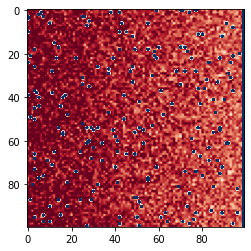

In [39]:
plt.imshow(c,vmin=0.0, vmax=10,cmap='RdBu');

In [40]:
# Transform 
#tnorm = c/scipy.linalg.norm(c,2)
tnorm = c
tsh1img = scipy.ndimage.shift(tnorm, 1, order=0, mode='nearest') # l,m = 1
tsh10img = scipy.ndimage.shift(tnorm, 10, order=0, mode='nearest') # l,m = 10

td1img = tnorm - tsh1img
td10img = tnorm - tsh10img
tX1 = td1img.flatten().reshape(-1,1)
tX10 = td10img.flatten().reshape(-1,1)
    

In [41]:
tX = td1img.flatten()
#tX = tX/np.std(tX)
tX = tX.reshape(-1,1)

N = np.arange(1, 11)
tmodels = [None for i in range(len(N))]

for i in range(len(N)):
    tmodels[i] = GaussianMixture(N[i]).fit(tX)

# compute the AIC and the BIC
tAIC = [m.aic(tX) for m in tmodels]
tBIC = [m.bic(tX) for m in tmodels]


In [45]:
means

[1.4749974877068832, -49.56122455558285]

In [46]:
best_mixtured_model = tmodels[2]
means = [best_mixtured_model.means_[0][0],best_mixtured_model.means_[1][0],best_mixtured_model.means_[2][0]]
classed_img = generate_mask(tX, means,best_mixtured_model)

0.018411006829581765 0
number of bad pixels: 494
number of dead pixels: 1


In [43]:
missed_pix = []
found_pix = []
for pix in coords:
    x = pix[0]
    y = pix[1]
    if classed_img[x,y] == 10:
        found_pix.append(c[x,y])
    elif classed_img[x,y] != 10:
        missed_pix.append(c[x,y])
all_bad_pix = np.where(classed_img.flatten()==100)[0] 
all_good_pix = np.where(classed_img.flatten()==0)[0] 


raw image shape: (100, 100)
norm image shape: (100, 100)
transformed image shape: (100, 100)
Found 294 of 300 assigned bad pixels
Did not find 6 of 300 assigned bad pixels
A total of 0 were found out of 300 10000 9708


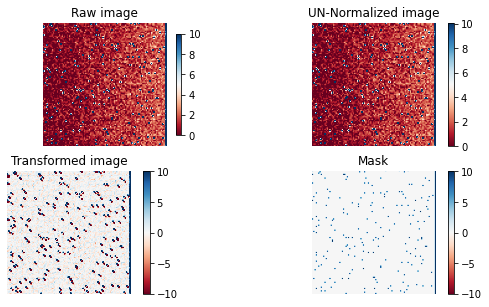

In [44]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax.set_title("Raw image")
p1 = ax.imshow(c,vmin=0.0, vmax=10,cmap='RdBu');
ax2.set_title("UN-Normalized image")
p2 = ax2.imshow(tnorm,vmin=-0.0, vmax=10.1,cmap='RdBu');
ax3.set_title("Transformed image")
p3 = ax3.imshow(td1img,vmin=-10.1, vmax=10.1,cmap='RdBu');
ax4.set_title("Mask")
p4 = ax4.imshow(classed_img,vmin=-10.1, vmax=10.1,cmap='RdBu');
f.colorbar(p1,ax=ax,fraction=0.02, pad=0.04);
f.colorbar(p2,ax=ax2);
f.colorbar(p3,ax=ax3);
f.colorbar(p4,ax=ax4);
f.patch.set_visible(False)
ax.axis('off');
ax2.axis('off');
ax3.axis('off');
ax4.axis('off');
print('raw image shape:', c.shape)
print('norm image shape:', tnorm.shape)
print('transformed image shape:', td1img.shape)
print(f'Found {len(found_pix)} of {len(coords)} assigned bad pixels')
print(f'Did not find {len(missed_pix)} of {len(coords)} assigned bad pixels')
print(f'A total of {len(all_bad_pix)} were found out of {len(coords)} {len(classed_img.flatten())} {len(all_good_pix)}') 

NameError: name 'models' is not defined

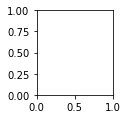

In [37]:
fig = plt.figure(figsize=(5, 1.7))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-1, 1, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

In [ ]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
#X = np.array([[1], [1], [1], [4], [12], [10]])
#bgm = BayesianGaussianMixture(n_components=3, random_state=42).fit(X)
bgm = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_process",
            n_components=3,
            covariance_type = 'spherical',
            #reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=42).fit(X)
#bgm.means_
#bgm.predict([[0, 0], [9, 3]])

In [61]:
np.log10(0.1)

-1.0

In [63]:
np.round(2)

2